**After this laboratory you should be able to**
- Understand the power law
- Explain the small world phenomena. Explain how the Wattz Strogath graph acomplishes this. Understand its drawbacks
- Understand the Barabasi-Albert model
- Explore the Kronecker Graph model

In [1]:
import networkx as nx
import numpy as np
import scipy
from scipy.io import mmread
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools
import os, sys
import random
from tqdm.notebook import tqdm

In [2]:
# Add utils
parent_dir = os.path.abspath(os.path.join('..'))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)
    
from utils.utils import average_clustering, average_degree, average_shortest_path_length_sampled, connectivity_perc, giant_component, load_graph

## Utils

In [3]:
# Download and load graphs. 
G_pgrid = load_graph("power-us-grid")
G_arvix = load_graph("arvix")
G_fb = load_graph("facebook")
G_wiki = load_graph("wiki")

In [9]:
G_pgrid = nx.from_scipy_sparse_matrix(mmread(os.path.join('..', 'data', 'power-US-Grid.mtx')))
G_arvix =nx.read_edgelist(os.path.join('..', 'data', 'collaboration_network_of_arxiv_general_relativity_category.txt'), create_using=nx.Graph)
G_fb = nx.read_edgelist(os.path.join('..', 'data', 'facebook_combined.txt'), create_using=nx.Graph)
G_wiki = nx.read_edgelist(os.path.join('..', 'data', 'wiki_vote.txt'), create_using=nx.Graph)


C:\Users\ZademnW\AppData\Local\Temp\ipykernel_9480\2408854933.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G_pgrid = nx.from_scipy_sparse_matrix(mmread(os.path.join('..', 'data', 'power-US-Grid.mtx')))


# Power law distribution

Probability density function:
$$f(x, a) = ax^{a-1}$$
for $0 \leq x \leq 1, a > 0$. $a$ is a shape parameter

In [4]:
a = .66
mean, var = st.powerlaw.stats(a, moments='mv') #mv = mean, variance
print(f"{mean = }")
print(f"{var = }")

mean = array(0.39759036)
var = array(0.09004221)


[ppf](https://stackoverflow.com/questions/65468026/norm-ppf-vs-norm-cdf-in-pythons-scipy-stats)

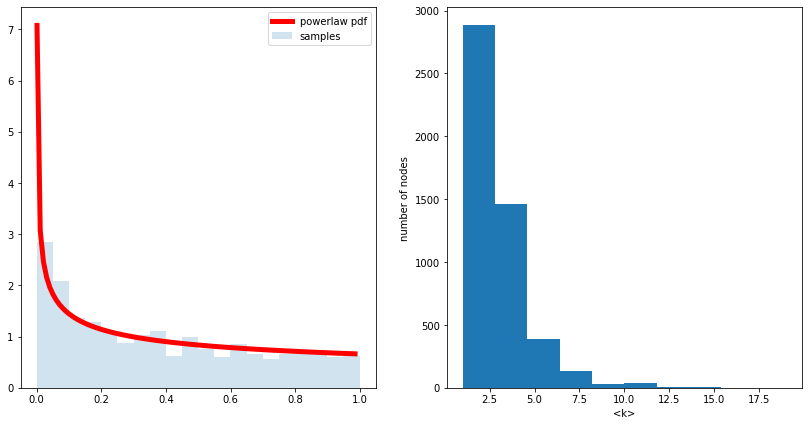

In [5]:
x = np.linspace(st.powerlaw.ppf(.01, a), st.powerlaw.ppf(.99, a), 100)
y = st.powerlaw.pdf(x, a) # probability density function at x

plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'r-', lw = 5, label = 'powerlaw pdf')

samples = [st.powerlaw(a).rvs() for _ in range(1000)]
plt.hist(samples, density = True, alpha = .2, label = 'samples', bins = 20)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([G_pgrid.degree(n) for n in G_pgrid.nodes], label = 'Real node distrib')
plt.xlabel('<k>')
plt.ylabel('number of nodes')
plt.show()

# Small world

**Motivation / Task**  
Can we have high clustering while also having short paths? 

*Intuition*
It states that if you choose any two individuals anywhere on Earth, you will find a path of at most six acquaintances between them

### Distances in small worlds
For a random network:
- we find $\langle k \rangle$ nodes at distance $1$
- we find $\langle k \rangle^2$ nodes at distance $2$
- we find $\langle k \rangle^d$ nodes at distance $d$
- Summing we get $N(d) = \sum_0^d \langle k \rangle ^d$

$\boxed{d_{max} \approx \dfrac {\log n} {\log \langle k \rangle}} \Rightarrow$ Distance rises way slower than the number of nodes -- **Small world phenomena**

In [6]:
print(G_fb)

Graph with 4039 nodes and 88234 edges


In [7]:
k_fb = average_degree(G_fb)
d_fb = average_shortest_path_length_sampled(G_fb, 250)
print(k_fb)
print(d_fb)

43.69101262688784
4.0


In [8]:
print(d_fb)
print(np.log(G_fb.number_of_nodes()) / np.log(k_fb))

4.0
2.198421846915431


## Watts-Storgatz model

In $G_{np}$ we saw that if we expand we get a good average shortest path length but there are no *triadic closures* (friend of a friend is my friend) -> low clustering. But if we make a network full of triadic closures (lattice-like) we get a high diameter. Can we combine them?

**Construction**  
1. Start: We start from a ring of nodes, each node being connected to their immediate and next neighbors $\to$ each node has $\langle C_i \rangle = \dfrac 3 4$ for $p = 0$.  
2. Rewiring phase: with probability $p$ cut a side and link it to another node

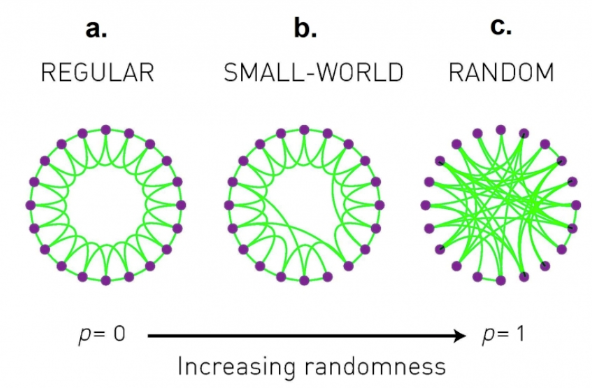

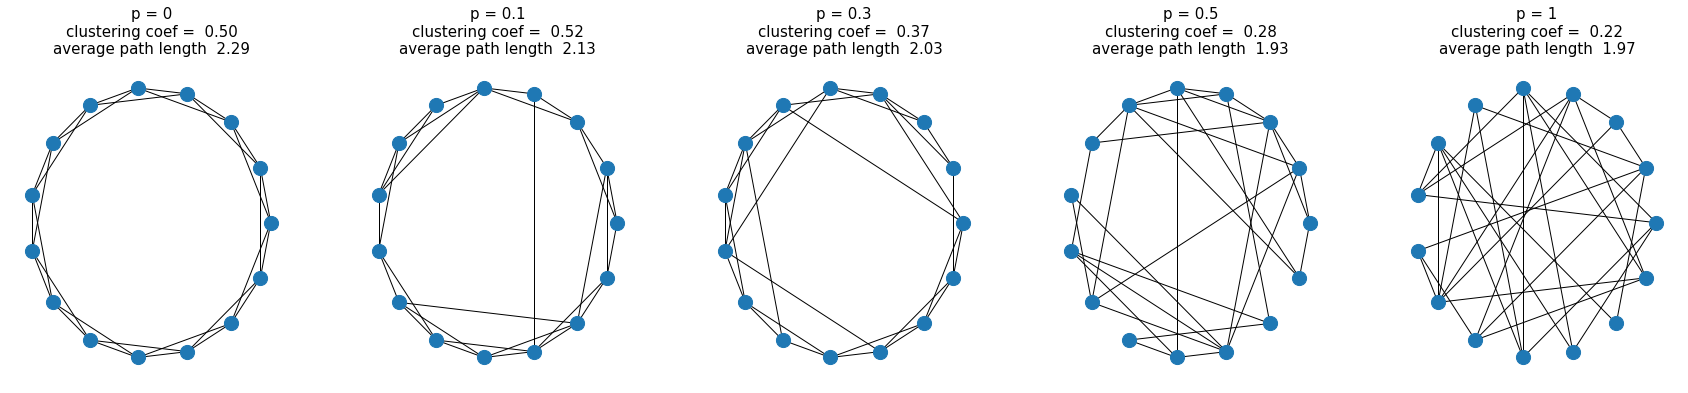

In [9]:
n = 15 # number of nodes
k = 4 # Ring topology neighbour connections
plt.figure(figsize = (30, 6))

for i, p in enumerate([0, .1, .3, .5, 1]):
    G = nx.watts_strogatz_graph(n, k, p) # p = probability of rewiring each edge
    plt.subplot(1, 5, i + 1)
    nx.draw_circular(G, node_size = 200)
    
    c = average_clustering(G)
    spl = nx.average_shortest_path_length(G)

    plt.title(f"{p = }\nclustering coef = {c: .2f}\naverage path length {spl: .2f}", size = 15)

In [10]:
# plot clustering coeff and average shortest path length 

n = 250
k = 4
ps = np.logspace(-3, 0, 40) # from 10^-3 to 10^0

clustering_coeffs = []
shortest_avg_path_lenghts = []
for p in tqdm(ps):
    G = nx.connected_watts_strogatz_graph(n, k, p)    
    c = nx.average_clustering(G)
    spl = nx.average_shortest_path_length(G)
    
    clustering_coeffs.append(c)
    shortest_avg_path_lenghts.append(spl)

  0%|          | 0/40 [00:00<?, ?it/s]

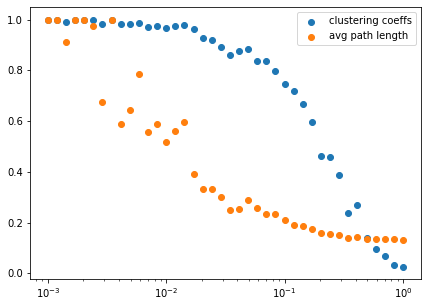

In [11]:
plt.figure(figsize = (7, 5))
# Both scaled
plt.scatter(ps, clustering_coeffs / np.max(clustering_coeffs) , label = "clustering coeffs")
plt.scatter(ps, shortest_avg_path_lenghts / np.max(shortest_avg_path_lenghts), label = "avg path length")

plt.xscale('log')

plt.legend()


**Properties**
- the rewiring creates $p \cdot n \cdot K/2$ *long range* links
- For small $p$
	- Local properties are still the same as the original mesh network
- Average path length drops dramatically as $p$ rises
- It takes a lot of randomness to ruin the clustering but a very small amount to create shortcuts

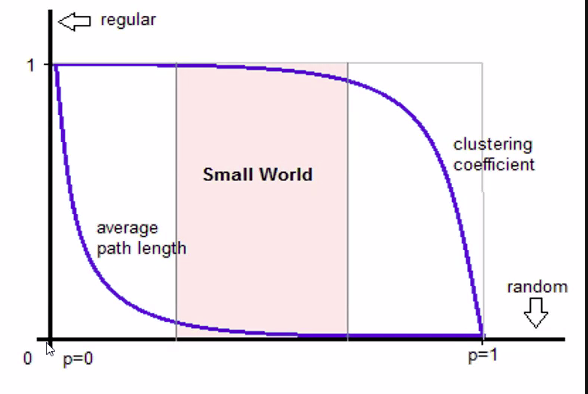

In [12]:

n = 100
k = 4
p = 0.1
G = nx.watts_strogatz_graph(n, k, p) # p = probability of rewiring each edge

In [13]:
average_degree(G)

4.0

**Limitations - small worlds**
- SW are *homogenous* $\to$ all nodes have approx the same number of edges
	- Simlar to ER-random
- Newman watts
	- We don't delete links, we add new links with probability $p$
	- no 2-link, no self-links
	- if $p = 0 \approx$ original nearest neighbor
	- if $p = 1 \to$ fully connected network (not random as $WS$)

- No **preferential attachment**

# Scale free

Random $ER$ and $SW$ networks have a degree distribution with a *peak* at an *average value* that decays exponentially $\to$ **Exponential networks**

In reality we have a **power-law** distirbution $\to$ scale-free property

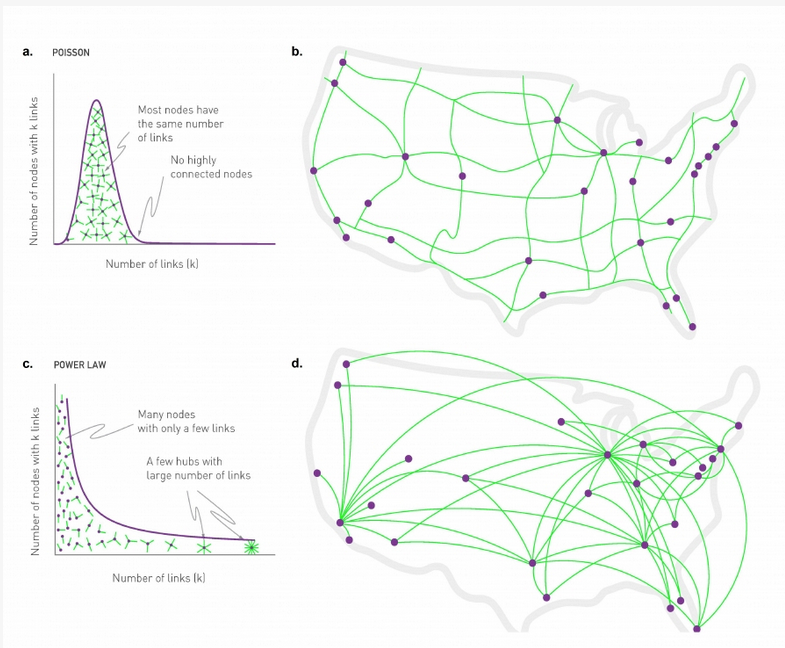

## Barabasi-albert model

**Construction**
1. Begin with an *Initial connected* network of $m_0$ nodes. 
2. At every iteration a new node added and connected to $m < m_0$ existing nodes
- The probability of wiring $p$ is proportial to the number of links that the existing nodes already have
$$\boxed{p_i = \dfrac {k_i} {\sum_j k_j}}$$

*Intuition*
- The probability is higher if that node has a higher degree $\to$ **Preference networks**
- Example: Higher chance to connect to celebrities

After $t$ iterations:  
Number of nodes: $N = t + m_0$ 
Number of edges: $E =  m\cdot t$ 

**Examples**
- Internet, Online communities (fb, twitter), genome, Airline networks


In [25]:
G.number_of_nodes()

21

In [24]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20))

In [26]:
def attach(node, m, G):
    """
    Add a new node based on preferential attachment
    Args:
        node: int
            The new node to add
        m: int
            Number of edges to attach from a new node to existing nodes
        G: nx.Graph
            The graph to add the node to 
    """
    
    assert(node == G.number_of_nodes()) 
    # Create a probability distribution for all nodes
    degrees = np.array([G.degree(u) for u in G.nodes])
    ps = degrees / np.sum(degrees)
    # Choose `m` nodes based on that probability distribution
    to_add = np.random.choice(node, p = ps, size = m, replace=False) 
    G.add_edges_from([(node, v) for v in to_add]) # add edges
    #G.add_edges_from(zip([node] * m, to_add)) # add edges


21

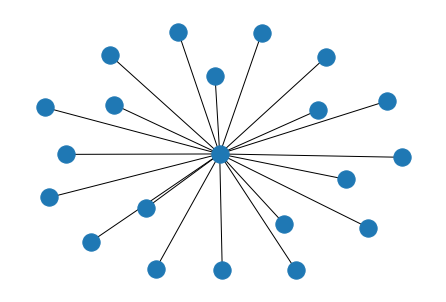

In [27]:
G = nx.star_graph(20)
nx.draw(G)
len(G)


In [32]:
def barabasi_albert_graph(n: int, m: int, initial_graph = None):
    """
    Return the Barabasi albert graph wih `n` nodes.
    Args:
        n: int
            Number of nodes
        m: int
            Number of edges to attach from a new node to existing nodes
        initial_graph: nx.Graph = None
            Give an initial graph to start with. If it's None start with a star graph of `m` nodes
            
    Returns:
        G: nx.Graph
            Barabasi albert graph with n nodes
    """
    
    if m< 1 or m >= n:
        raise ValueError(f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}")
    
    # Check initial graph
    if initial_graph is None:
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m and len(initial_graph) > n:
            raise ValueError(f"initial_graph needs between {m} and {n} nodes")
        G = initial_graph.copy()
    
    # For each new node we try to attach it to G
    for u in range(len(G), n):
        attach(u, m, G) # Add a new node `u` and connect it to m nodes. Modifies G inplace
    return G
        

Graph with 20 nodes and 100 edges


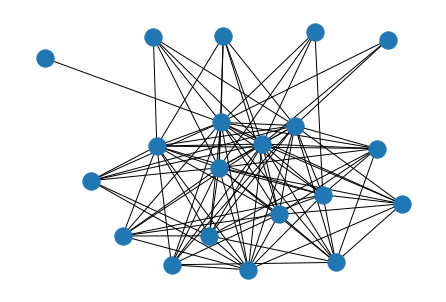

In [37]:
n = 20
m = 10
G = barabasi_albert_graph(n, m)
print(G)
nx.draw_kamada_kawai(G)

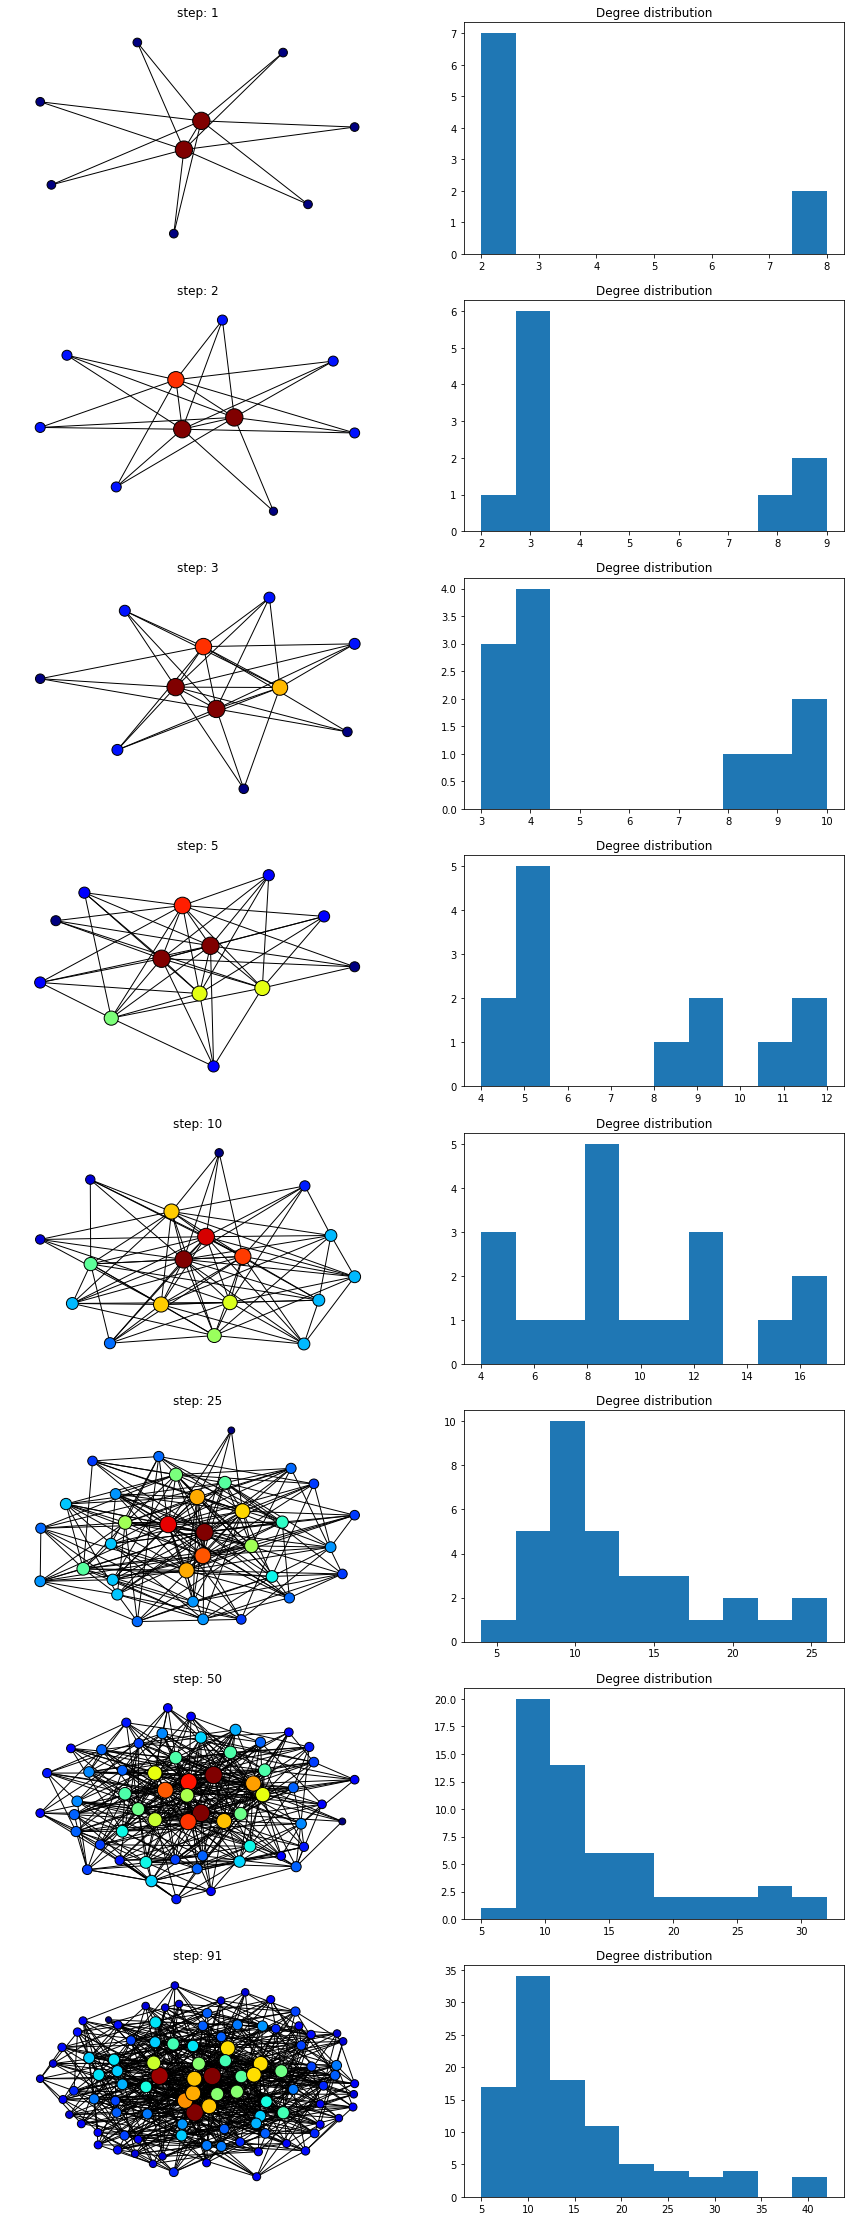

In [60]:
# Evolution:
n = 100 
m = 7

G = nx.star_graph(m) # Creata a star graph
m = len(G)
plot_steps = np.array([1, 2, 3, 5, 10, 25, 50, n-m-1]) # plot at these steps
plot_steps = plot_steps + m

i = 1
plt.figure(figsize = (15,  5 * 8))
for node in range(len(G), n):
    if node in plot_steps:
        # Plot graph
        plt.subplot(8, 2, i, title = f"step: {node - m}")
        sizes = np.array(list(nx.degree_centrality(G).values())) # Sizes and colors based on degree centrality
        sizes = sizes / max(sizes) * 300 # normalize to look pretty
        # Color and scale based on sizes to show importance
        #nx.draw_spring(G, node_size = sizes, edgecolors = 'black', node_color = sizes, cmap = plt.cm.jet)
        nx.draw_kamada_kawai(G, node_size = sizes, edgecolors = 'black', node_color = sizes, cmap = plt.cm.jet)
        i+=1 # switch to right plot 
        # Plot degree distribution
        plt.subplot(8, 2, i, title = "Degree distribution")
        plt.hist([G.degree(u) for u in G.nodes])
        i+=1 # switch to left plot 
    attach(node, m, G)

**Properties**
- Diameter $D \approx \dfrac {\log n} {\log \log n}$
- Avg path length $E = \dfrac {\ln n} {\ln \ln n}$
- Degree distribution $P(k) = k^{-3}$
- Clustering coef $C = \dfrac m 8 \cdot \dfrac {(\ln n)^2} n \approx n^{-0.75}$

In [61]:
n = 1000
m = 10s the “out” neighborhood or successors. If you want the neighborhood of predecessors first reverse the graph with D.reve
G = barabasi_albert_graph(n, m)
print(G)

Graph with 1000 nodes and 9900 edges


In [62]:
print(nx.diameter(G), np.log(n) / np.log(np.log(n)))
print(f"{average_clustering(G) = : .4f} == {m / 8 * np.log(n) ** 2 / n = :.4f}")

4 3.574249916581999
average_clustering(G) =  0.0586 == m / 8 * np.log(n) ** 2 / n = 0.0596


**Limitations - scale free**  
Does not capture 
- Variations in the shape of degree distribution (**linear** growth)
- Variations in the degree exponent (**linear** preferential attachement)
- Size independent clustering coeff
- First nodes have advantage (later nodes can't catch up) $\to$ not real

- No high levels of clustering

# Kronecker graph

- https://www.youtube.com/watch?v=Xnpt8US31cQ&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&index=44